In [1]:
#%matplotlib inline
%pylab inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import pandas as pd
import dask.dataframe as dd
import dask.array as da

from gsw import SA_from_SP, p_from_z, CT_from_pt, rho
from gsw import alpha, beta, cp_t_exact, sigma0

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cosima_cookbook as cc
session = cc.database.create_session()

In [3]:
#Input all data needed from the model for tenth degree
expt = '01deg_jra55v13_ryf9091'
x_u = cc.querying.getvar(expt,'xu_ocean',session,n=1).sel(xu_ocean=slice(-90,10))
x_t = cc.querying.getvar(expt,'xt_ocean',session,n=1).sel(xt_ocean=slice(-90,10))
y_u = cc.querying.getvar(expt,'yu_ocean',session,n=1).sel(yu_ocean=slice(10,65))
y_t = cc.querying.getvar(expt,'yt_ocean',session,n=1).sel(yt_ocean=slice(10,65))
z_t = cc.querying.getvar(expt,'st_ocean',session,n=1)

In [4]:
start_time = '2137-01-01'
end_time = '2137-12-31'
r0 = 6.371 * 10**6
av = 7.2921159 * 10**(-5)
rho_0 = 1026
g = 9.81
f = 2*av*np.sin((y_t*np.pi)/180)  #Coriolis Parameter

In [5]:
#1. Finding in-situ density
salt = cc.querying.getvar(expt,'surface_salt',session,ncfile ='ocean_daily.nc',start_time='2137-01-01',
                          end_time='2137-12-31').sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65))
salt = salt.sel(time=slice(start_time, end_time))
T = cc.querying.getvar(expt,'surface_temp',session,ncfile='ocean_daily.nc',start_time='2137-01-01',
                       end_time='2137-12-31').sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65))
T = T.sel(time=slice(start_time, end_time))
Y,Z,X =  np.meshgrid(y_t,z_t,x_t)
pressure_array = xr.DataArray(p_from_z(-Z,Y),  coords = [z_t, y_t, x_t],  
                              dims=['st_ocean','yt_ocean','xt_ocean'],name='pressure', attrs = {'units':'dbar'})
pressure_array_NA = pressure_array.sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65)).sel(
    st_ocean = 1,method = 'nearest')
rho_mat = rho(salt,T-273.15,pressure_array_NA)
#rho_mat.mean('time').plot.contourf(levels = np.linspace(1020,1032,41))

In [6]:
#2. Interpolating wind stress to centred coordinates to calculate Ekman Layer Depth 
import xgcm
tau_x = cc.querying.getvar(expt,'tau_x',session,ncfile ='ocean_daily.nc',start_time='2137-01-01',
                           end_time='2137-12-31').sel(yu_ocean=slice(10,65)).sel(xu_ocean=slice(-90,10))
tau_x = tau_x.sel(time=slice(start_time, end_time))
tau_y = cc.querying.getvar(expt,'tau_y',session,ncfile ='ocean_daily.nc',start_time='2137-01-01',
                           end_time='2137-12-31').sel(yu_ocean=slice(10,65)).sel(xu_ocean=slice(-90,10))
tau_y = tau_y.sel(time=slice(start_time, end_time))

tau_x = tau_x.rename('Wind stress in x direction')
tau_y = tau_y.rename('Wind stress in y direction')
paths = []
paths.append("/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf9091_gadi_retest/output328/ocean/ocean.nc")
data = xr.merge((tau_x,tau_y,T))
data.coords['xt_ocean'].attrs.update(axis='X')
data.coords['xu_ocean'].attrs.update(axis='X',c_grid_axis_shift = 0.5)
#data.coords['xu_ocean'].attrs.update(axis='X')
data.coords['yt_ocean'].attrs.update(axis='Y')
data.coords['yu_ocean'].attrs.update(axis='Y',c_grid_axis_shift = 0.5)
#data.coords['yu_ocean'].attrs.update(axis='Y')
#data.coords['st_ocean'].attrs.update(axis='Z')

temp = xgcm.Grid(data, periodic=['X'])
tempo = temp.interp(tau_x,'X')
tau_x_interp = temp.interp(tempo,'Y',boundary="extend")

temp = xgcm.Grid(data, periodic=['Y'])
tempo = temp.interp(tau_y,'Y')
tau_y_interp = temp.interp(tempo,'X',boundary="extend")

In [7]:
#2-3. Calculate Ekman Layer Depth
taumag = (tau_x_interp**2 + tau_y_interp**2)**0.5
abs_tau = abs(taumag)
ustar = (abs_tau/rho_mat)**0.5
ELD = 0.4*(ustar/f)

In [8]:
sigma = 26
extn = 0.25
potrho = sigma0(salt,T-273.15)

In [9]:
# We should be careful with using ELD or MLD. Here, ELD is used for all cases
Gradx_potrho = potrho.differentiate('xt_ocean')*(180/np.pi)/(r0*np.cos((potrho.yt_ocean*np.pi)/180))
Grady_potrho = potrho.differentiate('yt_ocean')*(180/np.pi)/r0
Jzf_ELD = (tau_x_interp*Grady_potrho - tau_y_interp*Gradx_potrho)/(rho_mat*ELD)
Jzf_ELD_clip = Jzf_ELD.where((potrho.values >= (sigma - extn)) & (potrho.values <= (sigma + extn)))

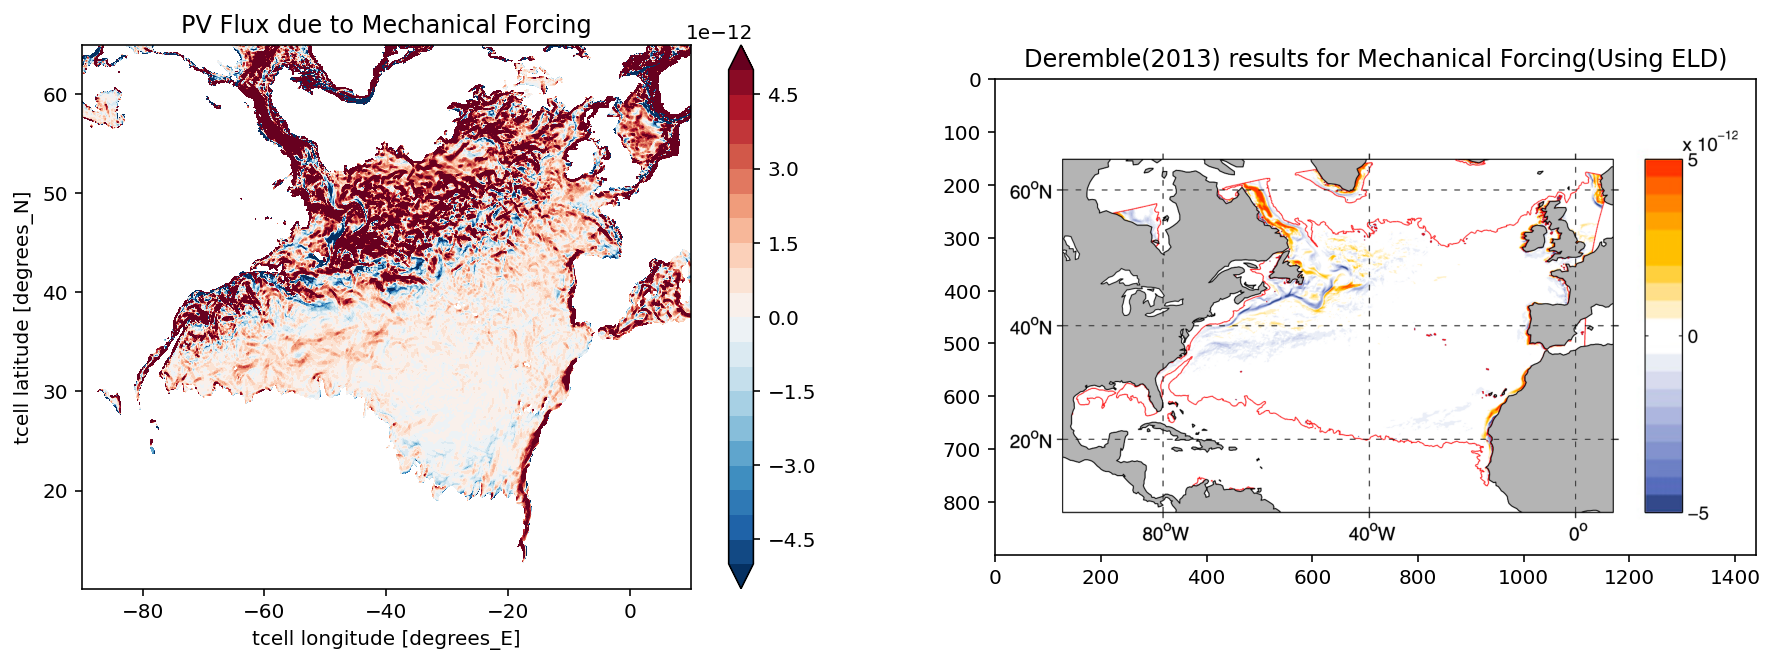

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(121)
Jzf_ELD_clip.mean('time').plot.contourf(levels = np.linspace(-5e-12,5e-12,21))
plt.title("PV Flux due to Mechanical Forcing")
#plt.text(0.4, 0.4,'Jzf')

img = mpimg.imread('/home/156/db6174/x77/Test_Notebooks/Figs/Jzf_5_day.png')

plt.subplot(122)
imgplot = plt.imshow(img)
plt.title("Deremble(2013) results for Mechanical Forcing(Using ELD)")
#plt.text(0.4, 0.4,'Jzf')

plt.show()

In [11]:
MLD = cc.querying.getvar(expt,'mld',session,ncfile ='ocean_daily.nc',start_time='2137-01-01',
                    end_time='2137-12-31').sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65))
MLD = MLD.sel(time=slice(start_time, end_time))
Jzf_MLD = (tau_x_interp*Grady_potrho - tau_y_interp*Gradx_potrho)/(rho_mat*MLD)
Jzf_MLD_clip = Jzf_MLD.where((potrho.values >= (sigma - extn)) & (potrho.values <= (sigma + extn)))

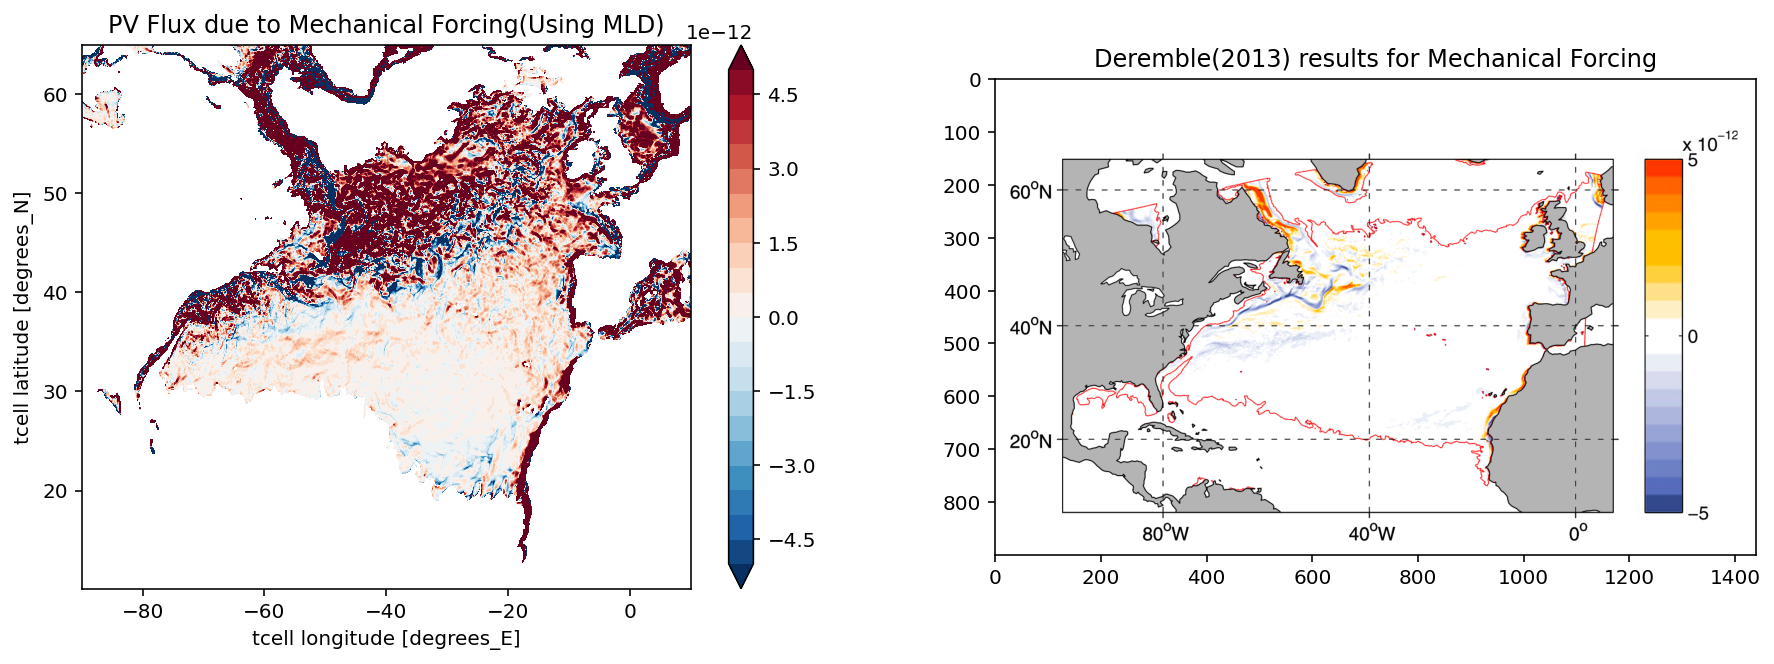

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(121)
Jzf_MLD_clip.mean('time').plot.contourf(levels = np.linspace(-5e-12,5e-12,21))
plt.title("PV Flux due to Mechanical Forcing(Using MLD)")
#plt.text(0.4, 0.4,'Jzf')

img = mpimg.imread('/home/156/db6174/x77/Test_Notebooks/Figs/Jzf_5_day.png')

plt.subplot(122)
imgplot = plt.imshow(img)
plt.title("Deremble(2013) results for Mechanical Forcing")
#plt.text(0.4, 0.4,'Jzf')

plt.show()

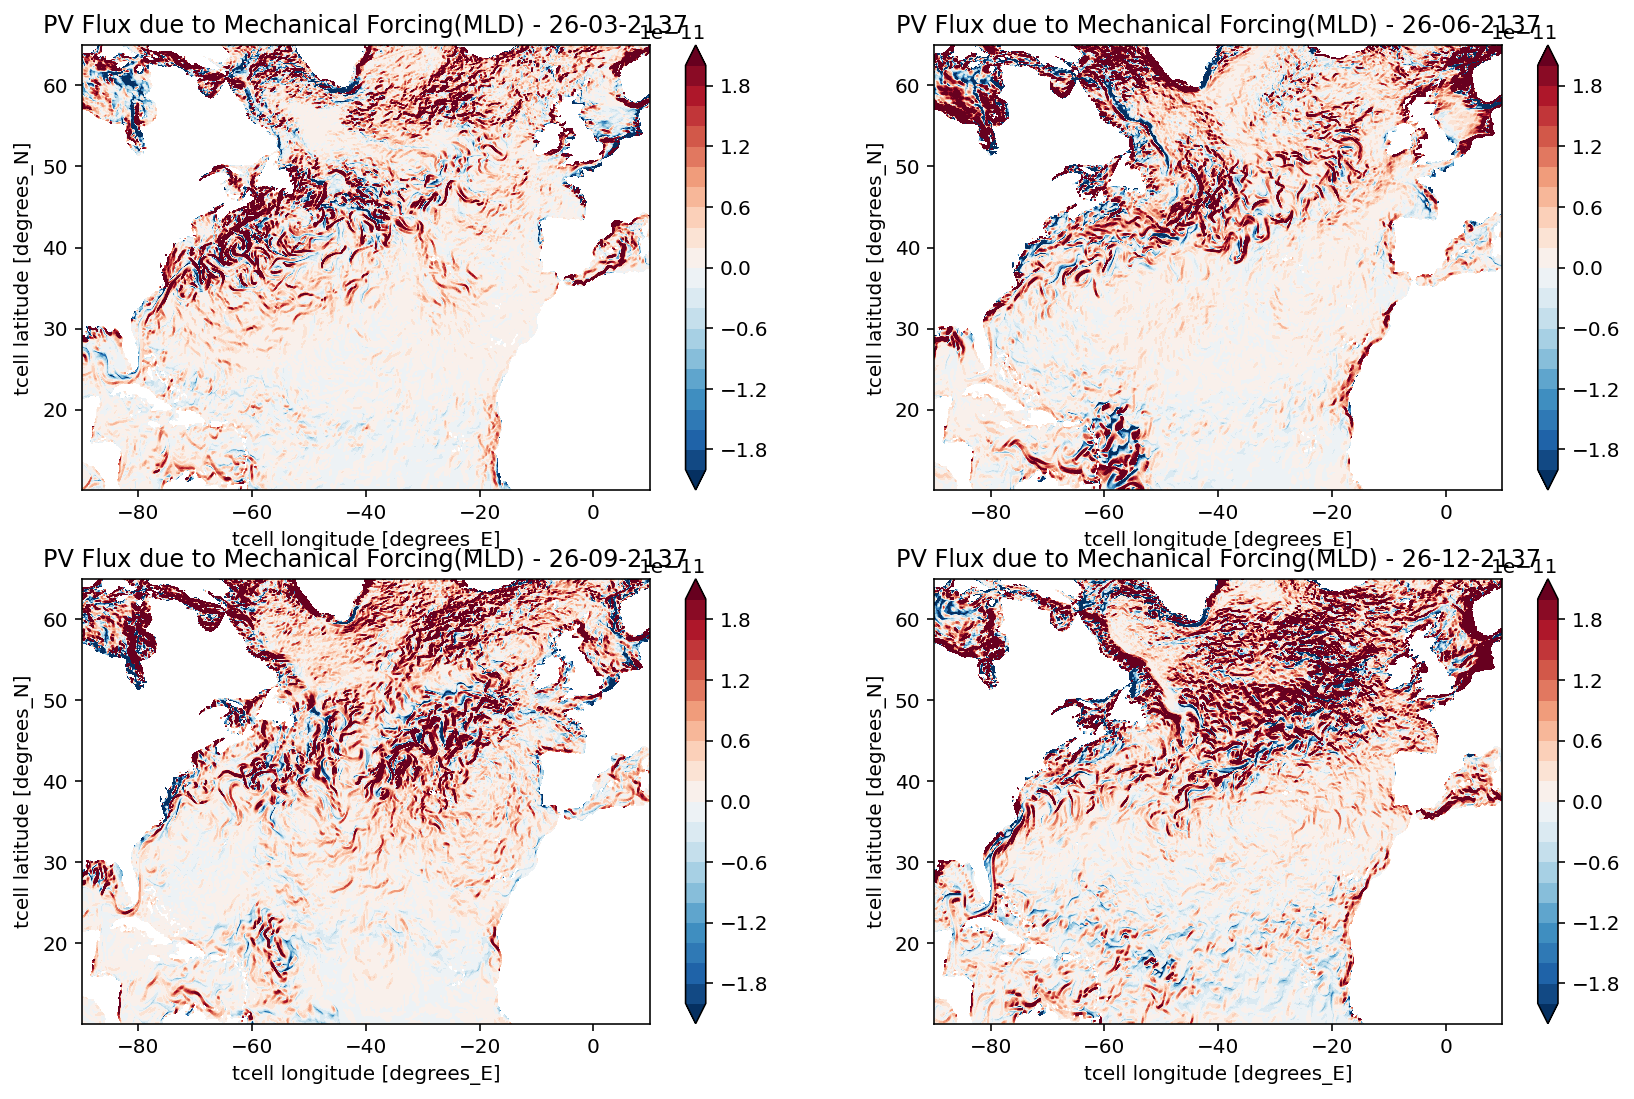

In [13]:
plt.figure(figsize=(14,9))

plt.subplot(221)
Jzf_spring = Jzf_ELD.sel(time=slice('2137-03-26', '2137-03-26'))
Jzf_spring.mean('time').plot.contourf(levels = np.linspace(-2e-11,2e-11,21))
plt.title("PV Flux due to Mechanical Forcing(MLD) - 26-03-2137")

plt.subplot(222)
Jzf_summer = Jzf_ELD.sel(time=slice('2137-06-26', '2137-06-26'))
Jzf_summer.mean('time').plot.contourf(levels = np.linspace(-2e-11,2e-11,21))
plt.title("PV Flux due to Mechanical Forcing(MLD) - 26-06-2137")

plt.subplot(223)
Jzf_autumn = Jzf_ELD.sel(time=slice('2137-09-26', '2137-09-26'))
Jzf_autumn.mean('time').plot.contourf(levels = np.linspace(-2e-11,2e-11,21))
plt.title("PV Flux due to Mechanical Forcing(MLD) - 26-09-2137")

plt.subplot(224)
Jzf_winter = Jzf_ELD.sel(time=slice('2137-12-26', '2137-12-26'))
Jzf_winter.mean('time').plot.contourf(levels = np.linspace(-2e-11,2e-11,21))
plt.title("PV Flux due to Mechanical Forcing(MLD) - 26-12-2137")

plt.show()

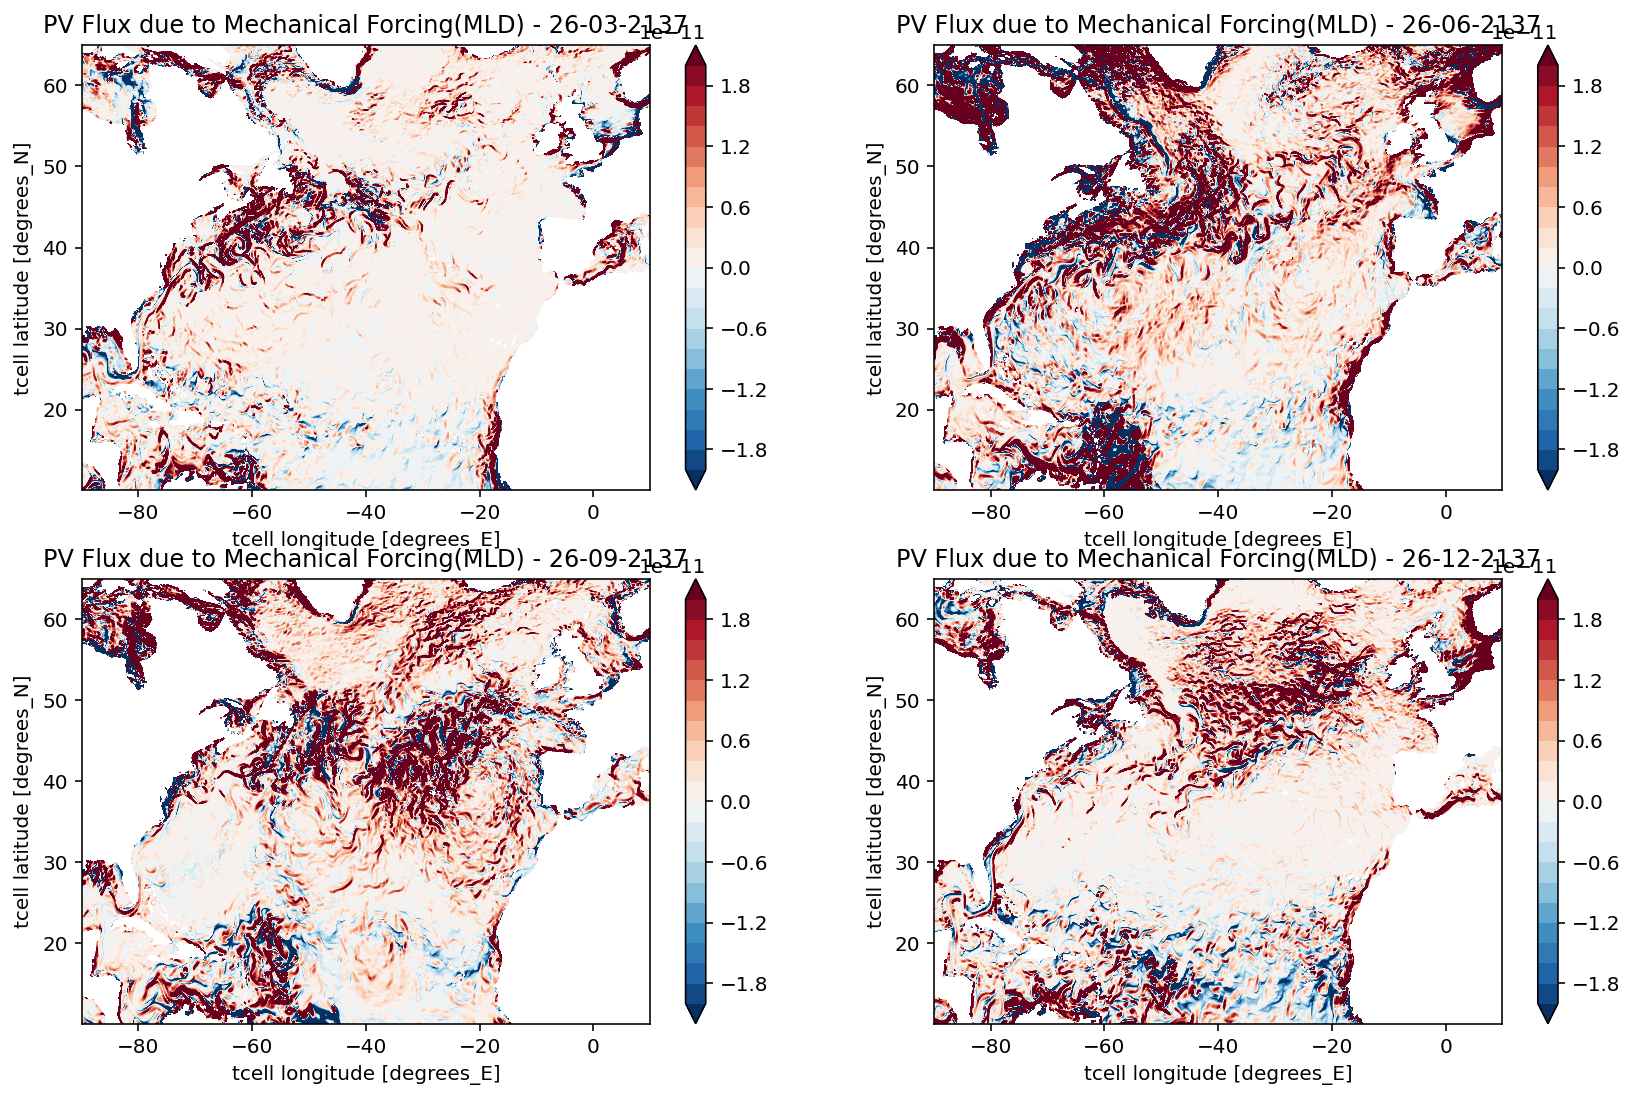

In [14]:
plt.figure(figsize=(14,9))

plt.subplot(221)
Jzf_spring = Jzf_MLD.sel(time=slice('2137-03-26', '2137-03-26'))
Jzf_spring.mean('time').plot.contourf(levels = np.linspace(-2e-11,2e-11,21))
plt.title("PV Flux due to Mechanical Forcing(MLD) - 26-03-2137")

plt.subplot(222)
Jzf_summer = Jzf_MLD.sel(time=slice('2137-06-26', '2137-06-26'))
Jzf_summer.mean('time').plot.contourf(levels = np.linspace(-2e-11,2e-11,21))
plt.title("PV Flux due to Mechanical Forcing(MLD) - 26-06-2137")

plt.subplot(223)
Jzf_autumn = Jzf_MLD.sel(time=slice('2137-09-26', '2137-09-26'))
Jzf_autumn.mean('time').plot.contourf(levels = np.linspace(-2e-11,2e-11,21))
plt.title("PV Flux due to Mechanical Forcing(MLD) - 26-09-2137")

plt.subplot(224)
Jzf_winter = Jzf_MLD.sel(time=slice('2137-12-26', '2137-12-26'))
Jzf_winter.mean('time').plot.contourf(levels = np.linspace(-2e-11,2e-11,21))
plt.title("PV Flux due to Mechanical Forcing(MLD) - 26-12-2137")

plt.show()

In [15]:
#1. Evaluating eddy entrainment component using fixed mixed layer depth (winter MLD)
Jzw = (0.7*rho_mat*f*ustar**3)/(g*MLD**2)
Jzw_clip = Jzw.where((potrho.values >= (sigma - extn)) & (potrho.values <= (sigma + extn)))

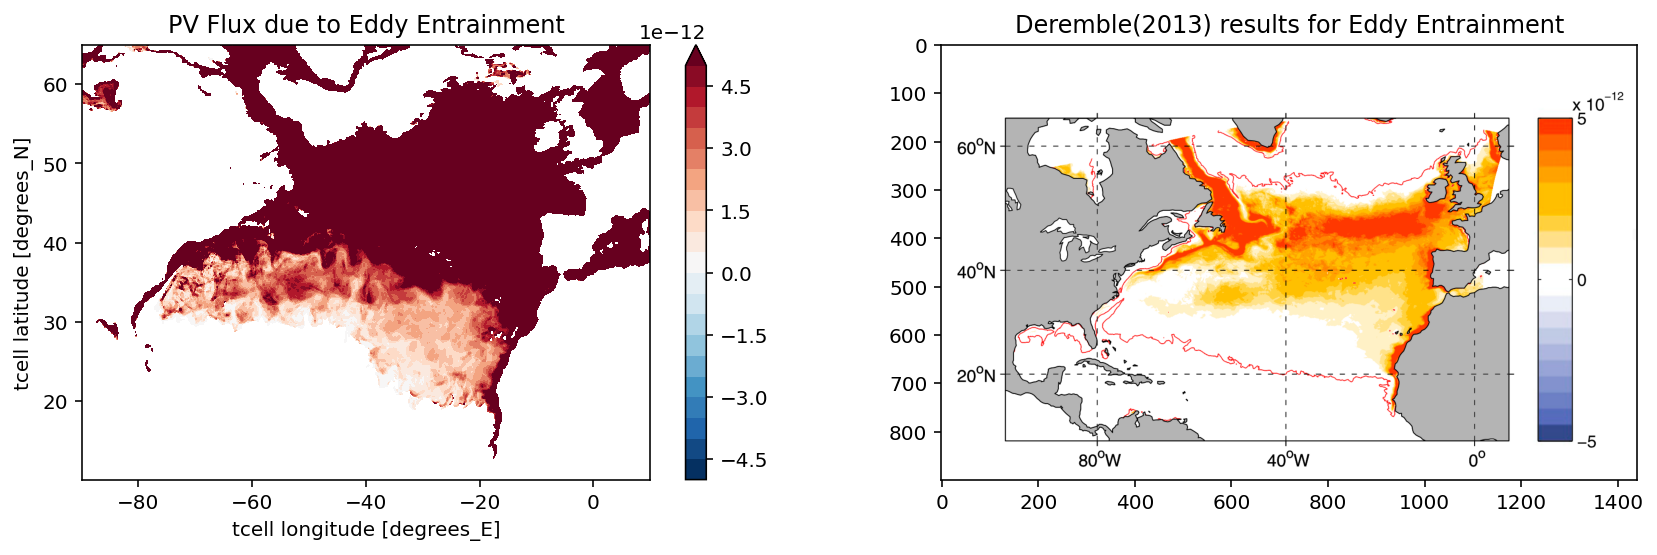

In [16]:
plt.figure(figsize=(14,4))
plt.subplot(121)
Jzw_clip.mean('time').plot.contourf(levels = np.linspace(-5e-12,5e-12,21))
plt.title("PV Flux due to Eddy Entrainment")
#plt.text(0.4, 0.4,'Jzf')

img = mpimg.imread('/home/156/db6174/x77/Test_Notebooks/Figs/Jzw_5_day.png')

plt.subplot(122)
imgplot = plt.imshow(img)
plt.title("Deremble(2013) results for Eddy Entrainment")
#plt.text(0.4, 0.4,'Jzf')

plt.show()

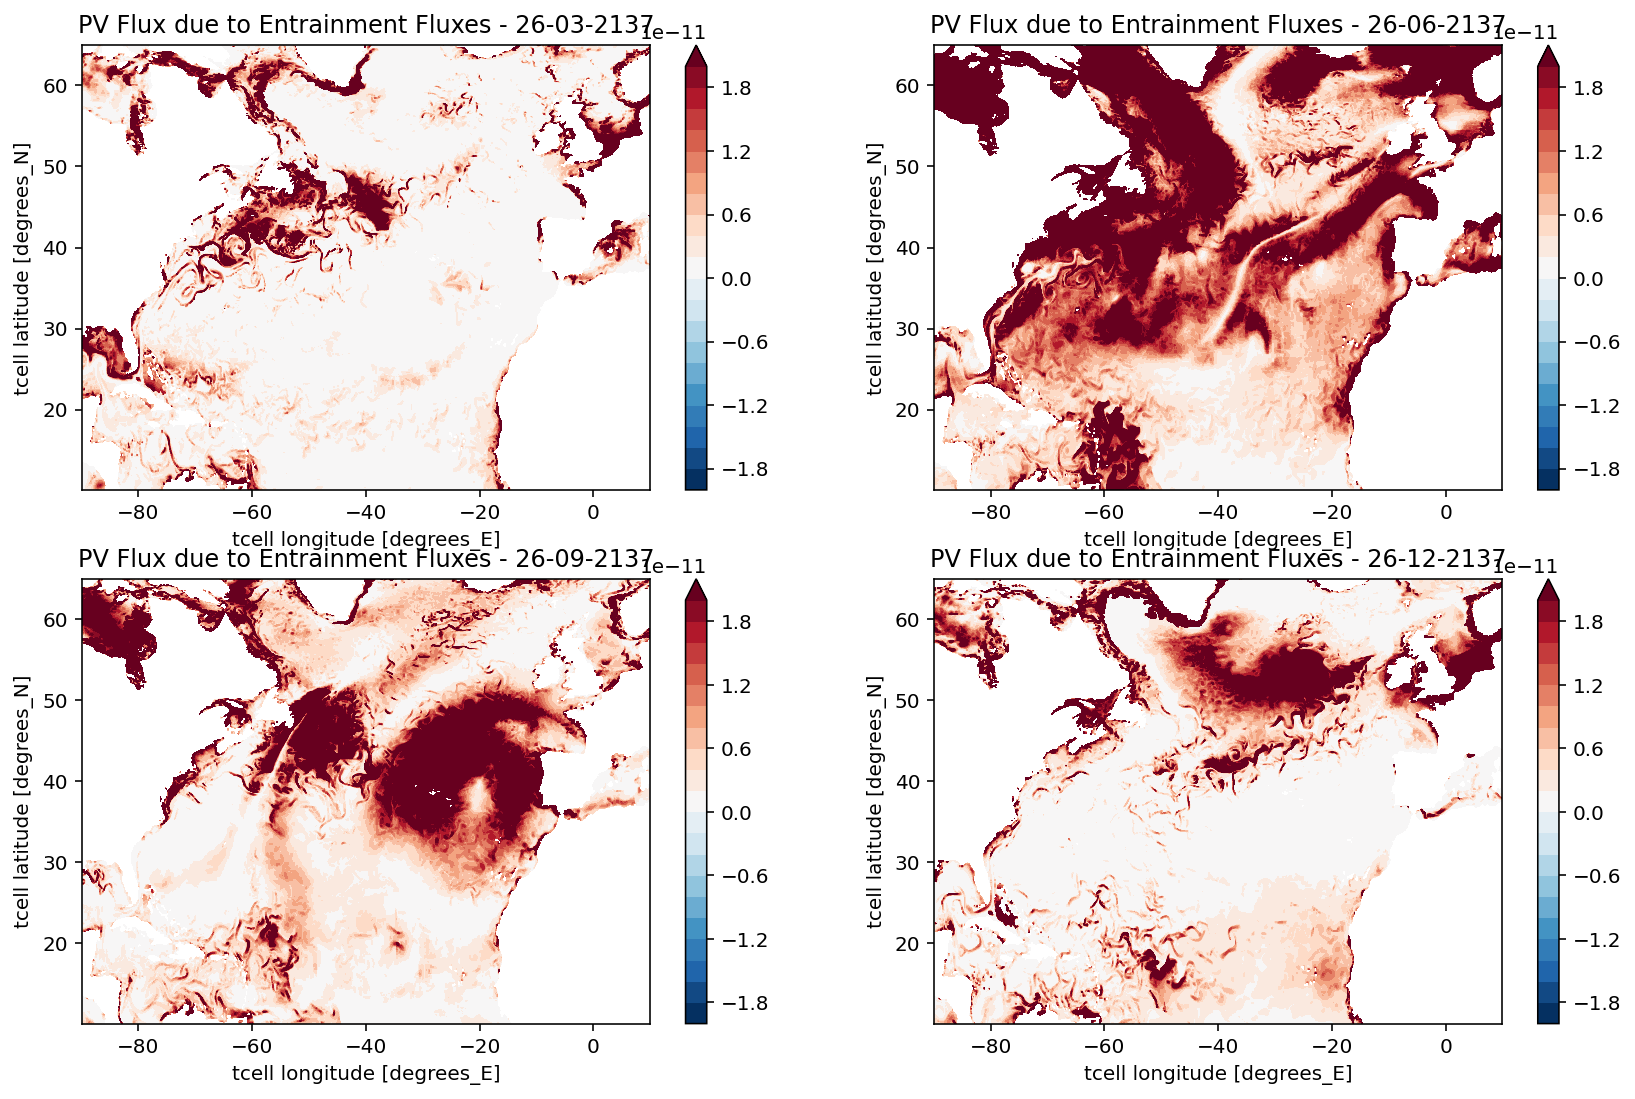

In [17]:
plt.figure(figsize=(14,9))

plt.subplot(221)
Jzw_spring = Jzw.sel(time=slice('2137-03-26', '2137-03-26'))
Jzw_spring.mean('time').plot.contourf(levels = np.linspace(-2e-11,2e-11,21))
plt.title("PV Flux due to Entrainment Fluxes - 26-03-2137")

plt.subplot(222)
Jzw_summer = Jzw.sel(time=slice('2137-06-26', '2137-06-26'))
Jzw_summer.mean('time').plot.contourf(levels = np.linspace(-2e-11,2e-11,21))
plt.title("PV Flux due to Entrainment Fluxes - 26-06-2137")

plt.subplot(223)
Jzw_autumn = Jzw.sel(time=slice('2137-09-26', '2137-09-26'))
Jzw_autumn.mean('time').plot.contourf(levels = np.linspace(-2e-11,2e-11,21))
plt.title("PV Flux due to Entrainment Fluxes - 26-09-2137")

plt.subplot(224)
Jzw_winter = Jzw.sel(time=slice('2137-12-26', '2137-12-26'))
Jzw_winter.mean('time').plot.contourf(levels = np.linspace(-2e-11,2e-11,21))
plt.title("PV Flux due to Entrainment Fluxes - 26-12-2137")

plt.show()

In [18]:
#1. Getting alpha, beta and cp from TEOS-10
alpha_mat = alpha(salt,T-273.15,pressure_array_NA)
beta_mat = beta(salt,T-273.15,pressure_array_NA)
cp_mat = cp_t_exact(salt,T-273.15,pressure_array_NA)

In [19]:
#2. Getting surface heat flux from various components.
sfc_heat_coupler = cc.querying.getvar(expt,'sfc_hflux_coupler',session,ncfile='ocean_daily.nc',start_time='2137-01-01',
                                      end_time='2137-12-31').sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65))
sfc_heat_coupler = sfc_heat_coupler.sel(time=slice(start_time, end_time))
sfc_heat_runoff = cc.querying.getvar(expt,'sfc_hflux_from_runoff',session,ncfile='ocean_daily.nc',start_time='2137-01-01',
                                      end_time='2137-12-31').sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65))
sfc_heat_runoff = sfc_heat_runoff.sel(time=slice(start_time, end_time))
sfc_heat_pme = cc.querying.getvar(expt,'sfc_hflux_pme',session,ncfile='ocean_daily.nc',start_time='2137-01-01',
                                      end_time='2137-12-31').sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65))
sfc_heat_pme = sfc_heat_pme.sel(time=slice(start_time, end_time))
#sfc_heat_frazil = cc.querying.getvar(expt,'frazil_3d_int_z',session,n=1).sel(
#    xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65))
total_sfc_hflux = sfc_heat_coupler + sfc_heat_runoff + sfc_heat_pme# + sfc_heat_frazil

In [20]:
#3. Precipitation and evaporation component
pme_river = cc.querying.getvar(expt,'pme_river',session,ncfile='ocean_daily.nc',start_time='2137-02-01',
                                      end_time='2137-12-31').sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65))
pme_river = pme_river.sel(time=slice(start_time, end_time))
fw_flux = -pme_river #Use pme_river since it has mass flux due to river flow too.

In [21]:
#4. Evaluating buoyancy component of generalized PV flux for fixed MLD
Jzb = -(alpha_mat*total_sfc_hflux*f)/(MLD*cp_mat) + (beta_mat*salt*fw_flux*f)/(MLD)
Jzb_clip = Jzb.where((potrho.values >= (sigma - 0.25)) & (potrho.values <= (sigma + 0.25)))

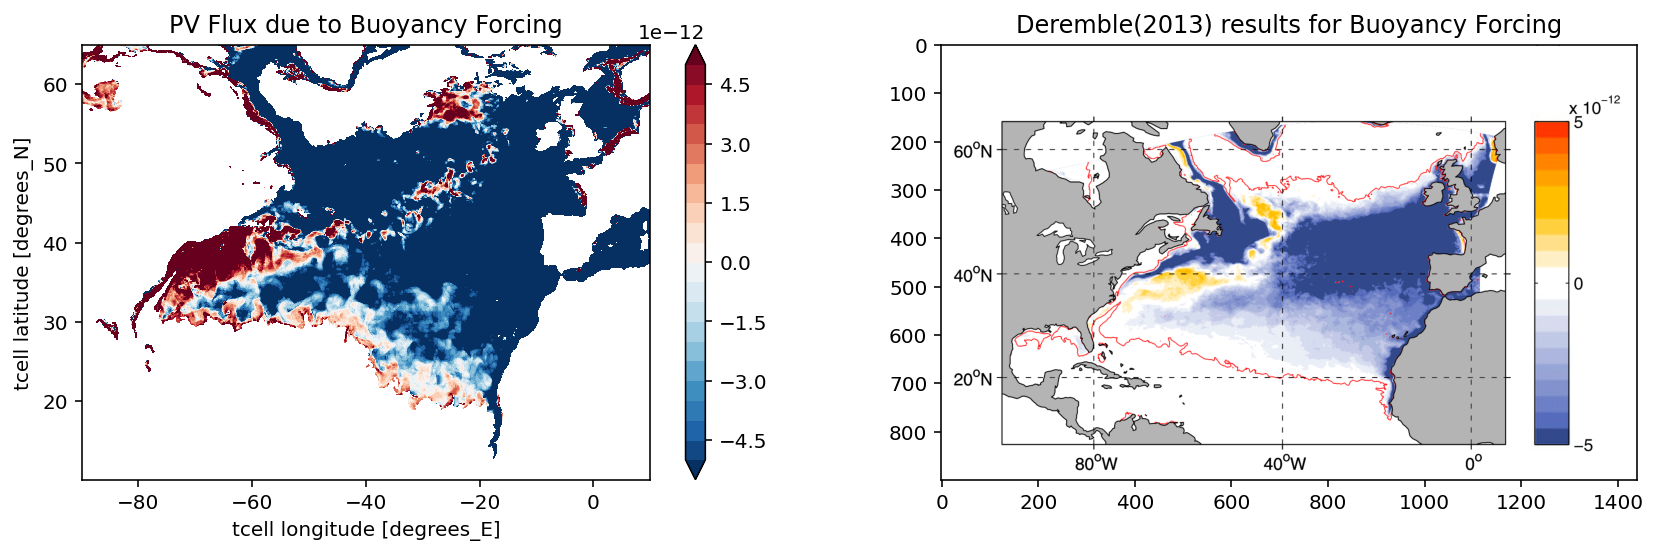

In [22]:
plt.figure(figsize=(14,4))
plt.subplot(121)
Jzb_clip.mean('time').plot.contourf(levels = np.linspace(-5e-12,5e-12,21))
plt.title("PV Flux due to Buoyancy Forcing")

img = mpimg.imread('/home/156/db6174/x77/Test_Notebooks/Figs/Jzb_5_day.png')

plt.subplot(122)
imgplot = plt.imshow(img)
plt.title("Deremble(2013) results for Buoyancy Forcing")
#plt.text(0.4, 0.4,'Jzf')

plt.show()

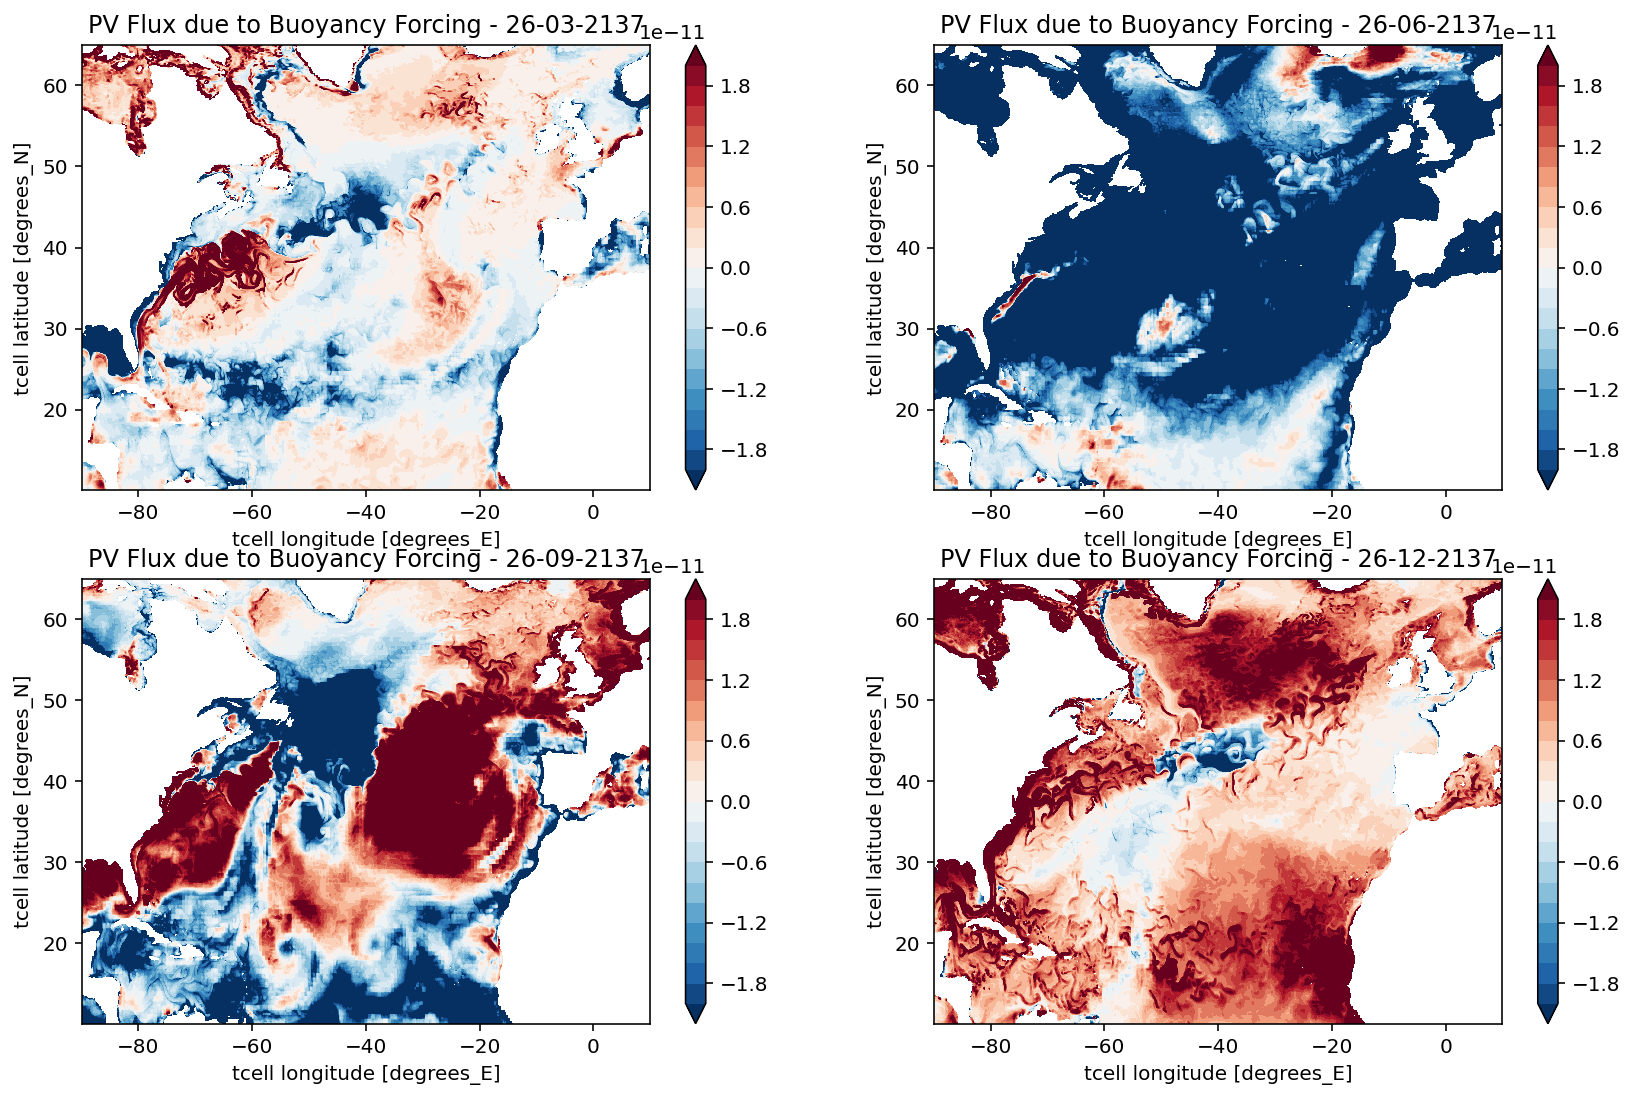

In [23]:
plt.figure(figsize=(14,9))

plt.subplot(221)
Jzb_spring = Jzb.sel(time=slice('2137-03-26', '2137-03-26'))
Jzb_spring.mean('time').plot.contourf(levels = np.linspace(-2e-11,2e-11,21))
plt.title("PV Flux due to Buoyancy Forcing - 26-03-2137")

plt.subplot(222)
Jzb_summer = Jzb.sel(time=slice('2137-06-26', '2137-06-26'))
Jzb_summer.mean('time').plot.contourf(levels = np.linspace(-2e-11,2e-11,21))
plt.title("PV Flux due to Buoyancy Forcing - 26-06-2137")

plt.subplot(223)
Jzb_autumn = Jzb.sel(time=slice('2137-09-26', '2137-09-26'))
Jzb_autumn.mean('time').plot.contourf(levels = np.linspace(-2e-11,2e-11,21))
plt.title("PV Flux due to Buoyancy Forcing - 26-09-2137")

plt.subplot(224)
Jzb_winter = Jzb.sel(time=slice('2137-12-26', '2137-12-26'))
Jzb_winter.mean('time').plot.contourf(levels = np.linspace(-2e-11,2e-11,21))
plt.title("PV Flux due to Buoyancy Forcing - 26-12-2137")

plt.show()

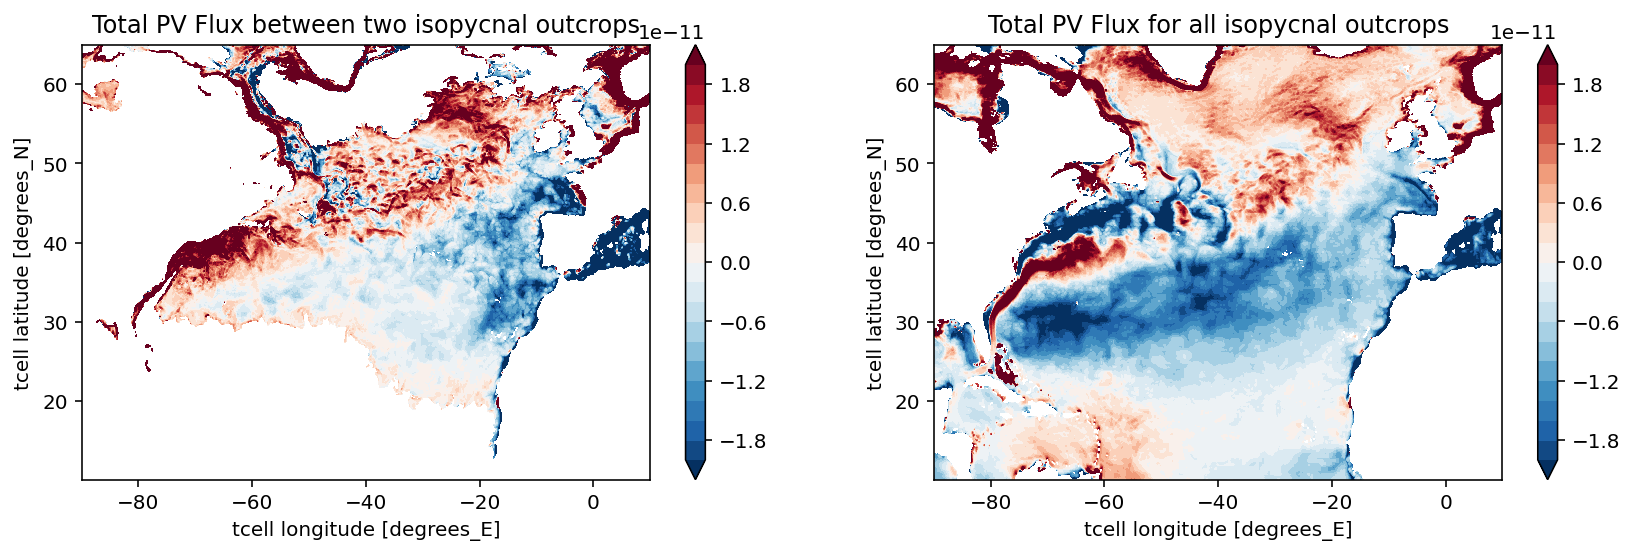

In [24]:
## Total PV between specific outcropping isopycnals
Jzf = Jzf_ELD.chunk((1,675,800))
Jzw = Jzw.chunk((1,675,800))

Jz_total_clip = Jzf_ELD_clip + Jzb_clip + Jzw_clip
Jz_total = Jzf + Jzb + Jzw

plt.figure(figsize=(14,4))

plt.subplot(121)
Jz_total_clip.mean('time').plot.contourf(levels = np.linspace(-2e-11,2e-11,21))
plt.title("Total PV Flux between two isopycnal outcrops")

plt.subplot(122)
Jz_total.mean('time').plot.contourf(levels = np.linspace(-2e-11,2e-11,21))
plt.title("Total PV Flux for all isopycnal outcrops")

plt.show()

### Comparing with Guillaume Maze results

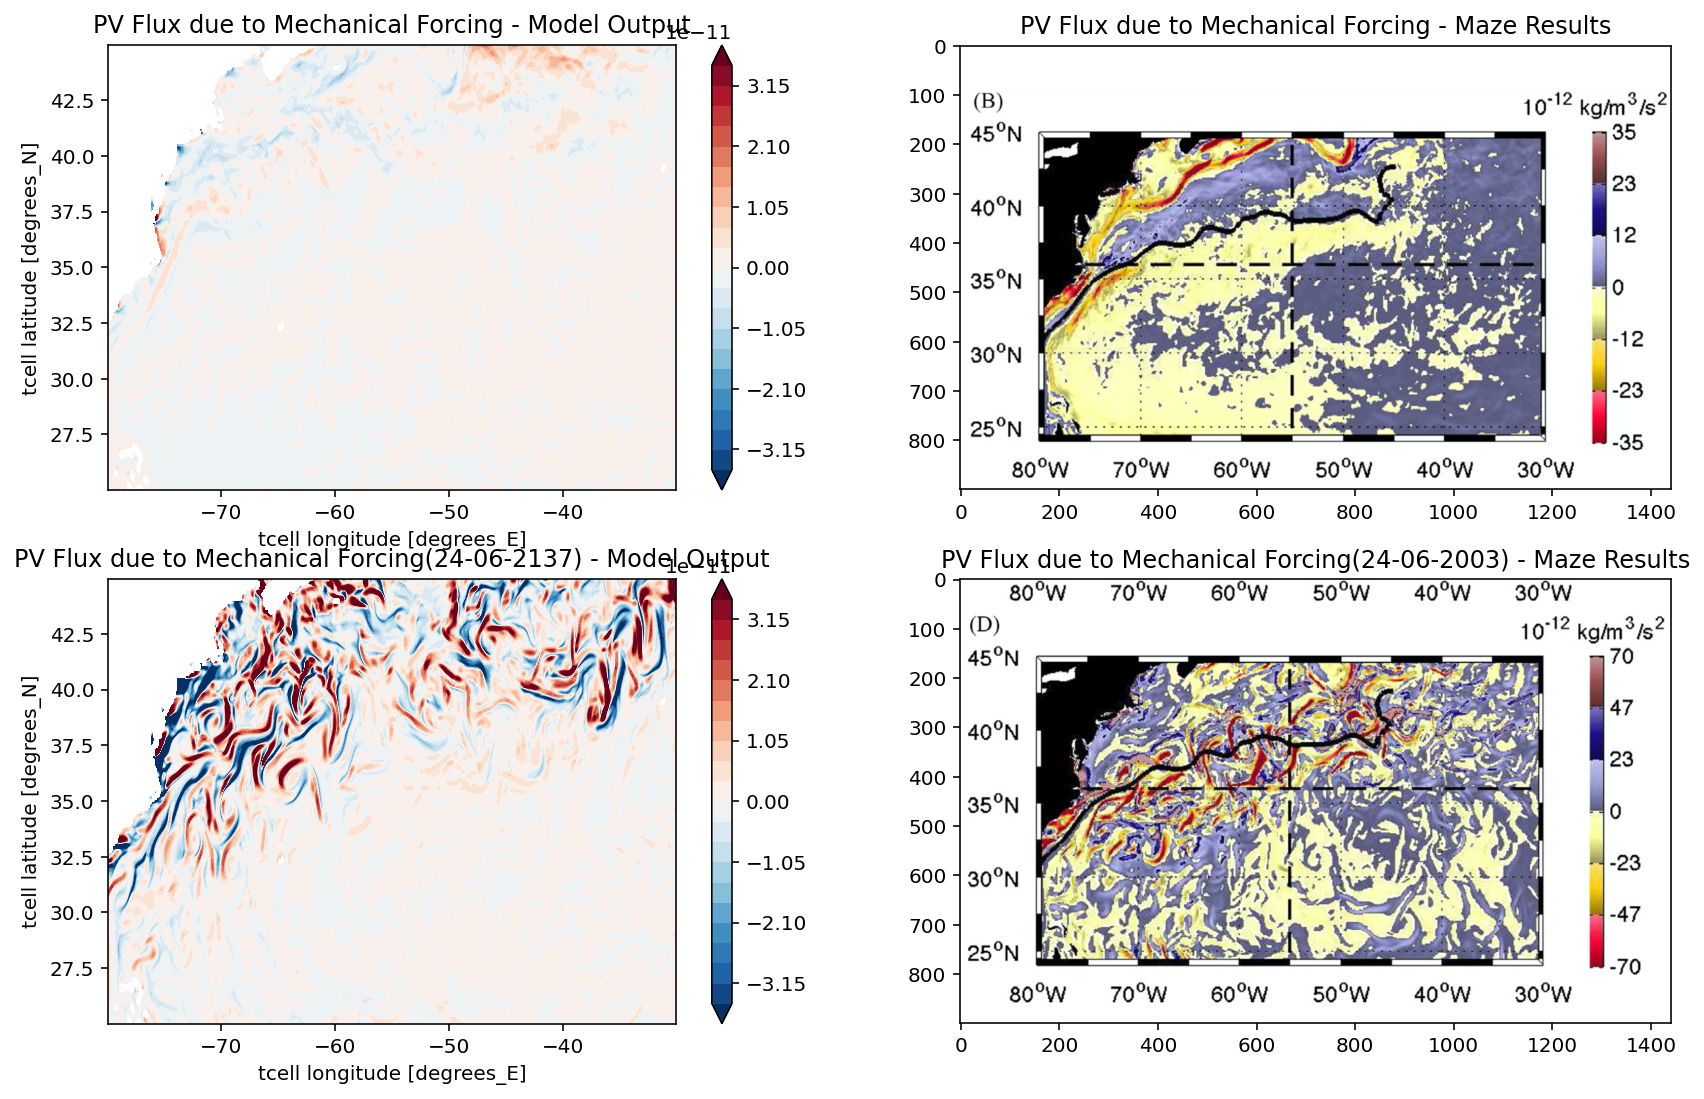

In [25]:
Jzf_ELD_crop = Jzf_ELD.sel(xt_ocean=slice(-80,-30)).sel(yt_ocean=slice(25,45))
Jzf_ELD_26 = Jzf_ELD_crop.sel(time=slice('2137-06-24','2137-06-24'))

plt.figure(figsize=(14,9))

plt.subplot(221)
Jzf_ELD_crop.mean('time').plot.contourf(levels = np.linspace(-3.5e-11,3.5e-11,21))
plt.title("PV Flux due to Mechanical Forcing - Model Output")

img = mpimg.imread('/home/156/db6174/x77/Test_Notebooks/Figs_Maze/Jz_f.png')

plt.subplot(222)
imgplot = plt.imshow(img)
plt.title("PV Flux due to Mechanical Forcing - Maze Results")

plt.subplot(223)
Jzf_ELD_26.mean('time').plot.contourf(levels = np.linspace(-3.5e-11,3.5e-11,21))
plt.title("PV Flux due to Mechanical Forcing(24-06-2137) - Model Output")

img = mpimg.imread('/home/156/db6174/x77/Test_Notebooks/Figs_Maze/Jz_f_26.png')

plt.subplot(224)
imgplot = plt.imshow(img)
plt.title("PV Flux due to Mechanical Forcing(24-06-2003) - Maze Results")

plt.show()

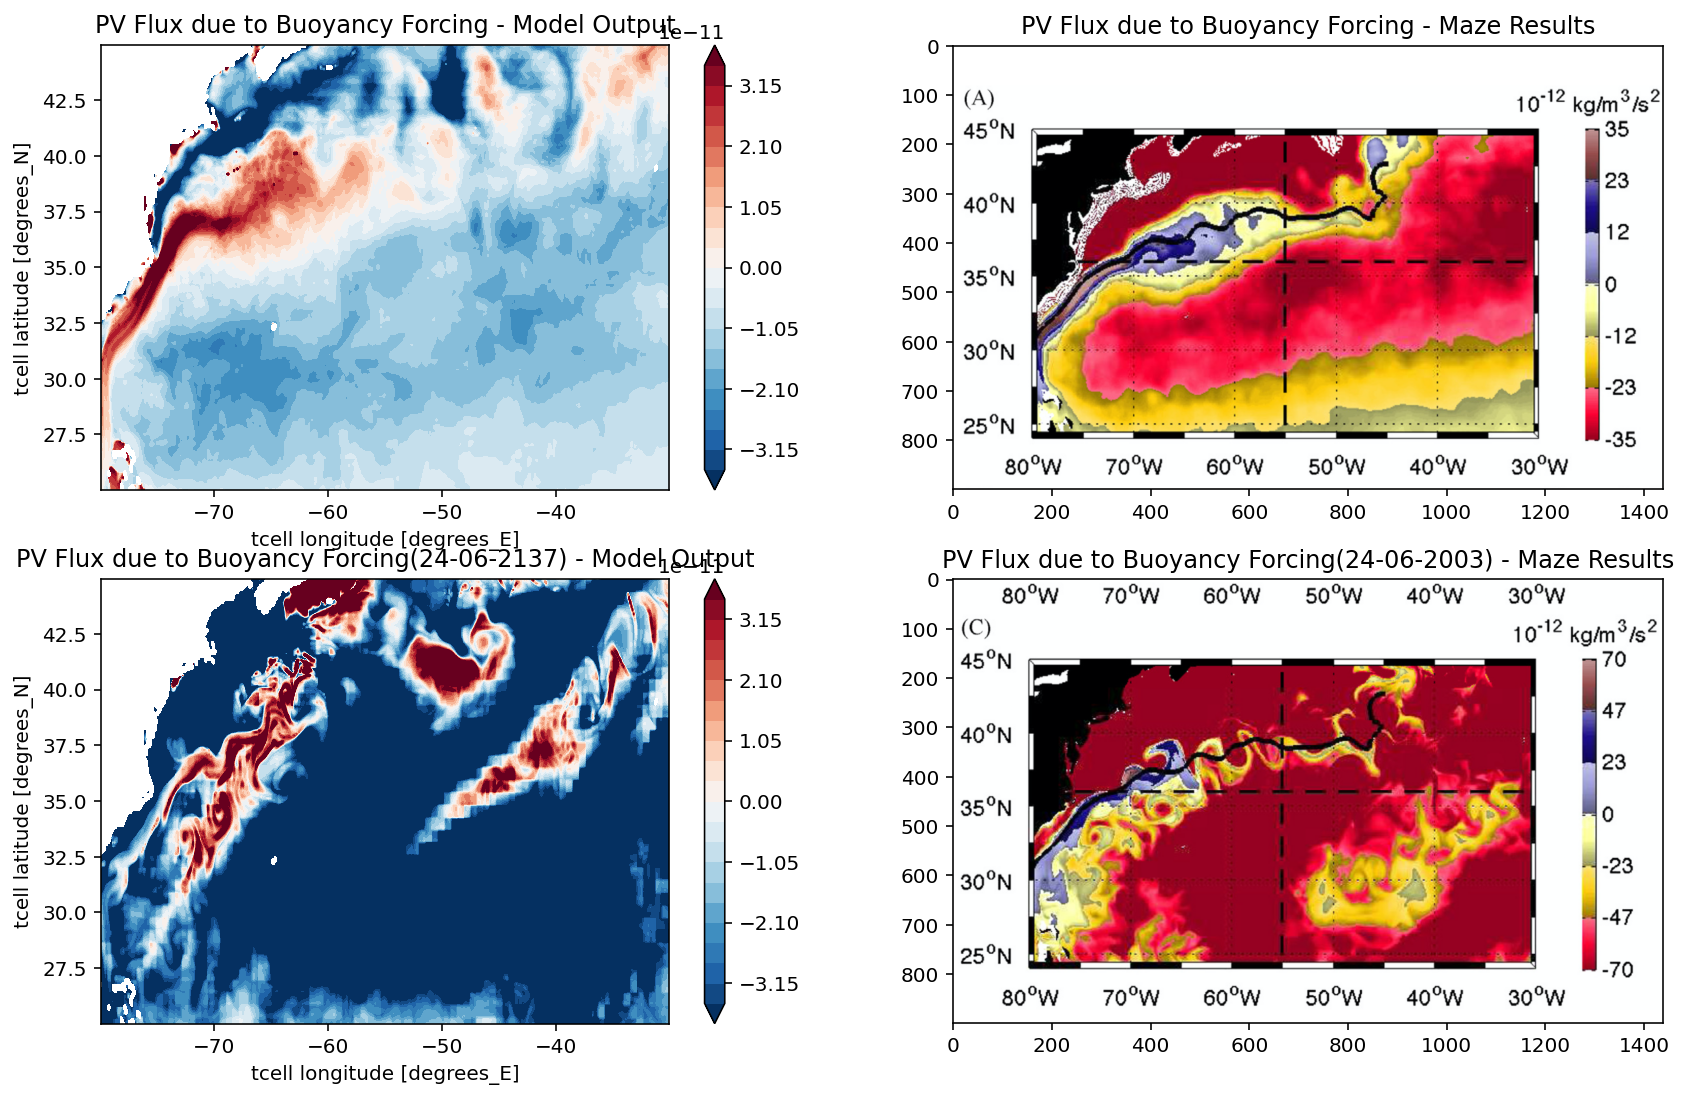

In [26]:
Jz_diab = (Jzb+Jzw)
Jz_diab_crop = Jz_diab.sel(xt_ocean=slice(-80,-30)).sel(yt_ocean=slice(25,45))
Jz_diab_26 = Jz_diab_crop.sel(time=slice('2137-06-24','2137-06-24'))

plt.figure(figsize=(14,9))

plt.subplot(221)
Jz_diab_crop.mean('time').plot.contourf(levels = np.linspace(-3.5e-11,3.5e-11,21))
plt.title("PV Flux due to Buoyancy Forcing - Model Output")

img = mpimg.imread('/home/156/db6174/x77/Test_Notebooks/Figs_Maze/Jz_diab.png')

plt.subplot(222)
imgplot = plt.imshow(img)
plt.title("PV Flux due to Buoyancy Forcing - Maze Results")

plt.subplot(223)
Jz_diab_26.mean('time').plot.contourf(levels = np.linspace(-3.5e-11,3.5e-11,21))
plt.title("PV Flux due to Buoyancy Forcing(24-06-2137) - Model Output")

img = mpimg.imread('/home/156/db6174/x77/Test_Notebooks/Figs_Maze/Jz_diab_26.png')

plt.subplot(224)
imgplot = plt.imshow(img)
plt.title("PV Flux due to Buoyancy Forcing(24-06-2003) - Maze Results")

plt.show()